# Features comparison

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
import scipy
from scipy import stats
from tqdm.notebook import trange, tqdm

import sys
sys.path.append("..") # Adds higher directory to python modules path.

from DataHelper import *
from StocksDataWrapper import StocksDataWrapper

%matplotlib inline
%load_ext autoreload
%autoreload 2

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
DATA_PATH = '../data/'
QUOTATION = 'AAPL'
FILE_SUFFIX = '.txt'

In [47]:
predict_n = 1
NORMALIZE_FEATURES = True
dataset = StocksDataWrapper.read_from(f"{DATA_PATH}{QUOTATION}{FILE_SUFFIX}", compute_features=True, normalize=NORMALIZE_FEATURES, predict_n=predict_n)

dataset.head()

df = dataset.df

0         2.992857
1         3.059286
2         3.037500
3         3.052500
4         3.306072
           ...    
3520    131.970001
3521    136.690002
3522    134.869995
3523    133.720001
3524    132.690002
Name: Close, Length: 3525, dtype: float64


In [48]:
def compute_t_test_classes(df, feature_names, classes, class_column='Next', equal_var=False):
    feature_p_vals = {}
    for feature in feature_names:
        # get the filtered series with only the feature, filtered by the target class
        a = df[df[class_column] == classes[0]][feature]
        b = df[df[class_column] == classes[1]][feature]


        t_stat, p_computed = stats.ttest_ind(a, b, equal_var = equal_var)
        feature_p_vals[feature] = p_computed
            
    # return the dictionary sorted by p_value (ASC)
    return {k: v if not np.isnan(v) else 1.0 for k, v in sorted(feature_p_vals.items(), key=lambda item: item[1])}

classes = list(df['Next'].value_counts().to_dict().keys())
test_feature_names = feature_names + ['Volume', 'Close']
test_feature_names = [feature for feature in test_feature_names if feature not in ['Next','Tendency']] 

feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)

print(feature_p_vals)

{'Difference': 0.005710653131743787, 'LowLen': 0.029777583894248318, 'PercentageDiff': 0.04275824773637527, 'RSI(14)': 0.0492926919744894, 'StochOsc': 0.11951510702082754, 'MACD': 0.1494703940620993, 'RSI_diff': 0.16947288825554116, 'MACD_signal': 0.17430603992094876, 'SMA(20) - SMA(10)': 0.20728195615592052, 'BG_H_Band_Indicator': 0.23862888054845677, 'GAP': 0.2423832382904714, 'ROC': 0.24296998015774482, 'Volume_diff': 0.2580783304216221, 'MACD_diff': 0.5637080490407335, 'Volume': 0.5658823701616695, 'BG_L_Band_Indicator': 0.7156366428232781, 'EMA_Diff': 0.8934670702089537, 'BG_H_Band': 0.9098910055682874, 'SMA(20)': 0.9273372099967607, 'BodyLen': 0.9451284898414647, 'BG_L_Band': 0.9478201247211804, 'EMA(14)': 0.9537837145833891, 'Close': 0.9603171416661713, 'SMA(10)': 0.968107065378472}


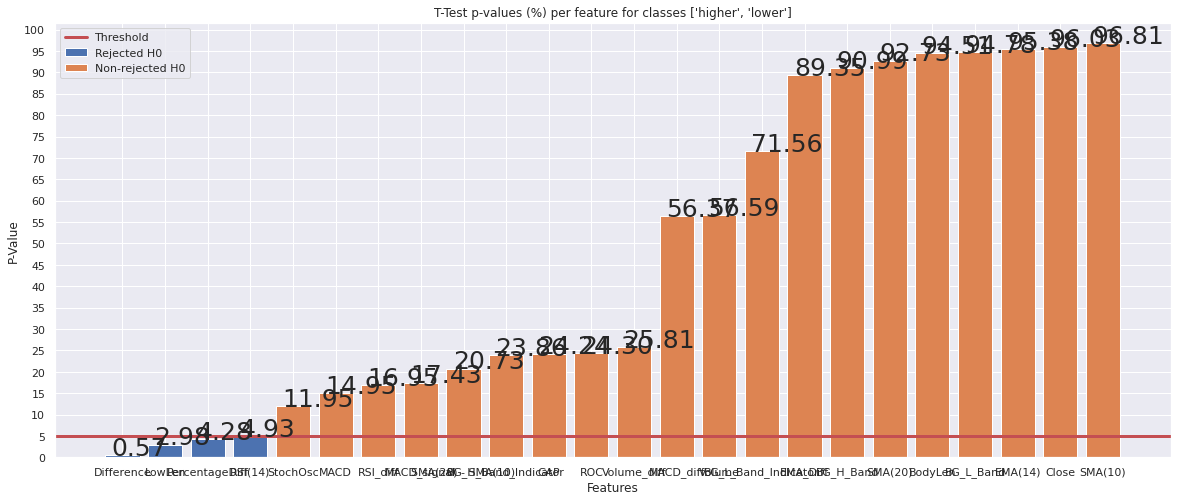

In [49]:
P_THRESH = 0.05


lowers = [(label, val) for label, val in feature_p_vals.items() if val <= P_THRESH]
highers = [(label, val) for label, val in feature_p_vals.items() if val > P_THRESH]


plt.bar([t[0] for t in lowers], [t[1]*100 for t in lowers], label="Rejected H0") 
plt.bar([t[0] for t in highers], [t[1]*100 for t in highers], label="Non-rejected H0")


x_locs, _ = plt.xticks()
for i, value in enumerate([x*100 for x in feature_p_vals.values()]):
    plt.text(x_locs[i] - 0.25, value + 0.01, f"{value:.2f}")
    
plt.axhline(y = P_THRESH * 100, color = 'r', linestyle = '-', linewidth=3.0, label="Threshold")
plt.yticks(np.arange(0, 101, step=5))
plt.title(f"T-Test p-values (%) per feature for classes {classes}")
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.show()

In [50]:
df_dict = StocksDataWrapper.import_folder(DATA_PATH, files_pattern="*.txt", compute_features=True, normalize=NORMALIZE_FEATURES)

higher_features_dict = {k:0 for k,v in feature_p_vals.items()}
lower_features_dict = {k:0 for k,v in feature_p_vals.items()}

# for each dataset given count the times where the features was higher or lower than the threshold
for (dataset, label) in tqdm(df_dict.items()):
    df = dataset.df
    feature_p_vals = compute_t_test_classes(df, test_feature_names, classes)
    for k,v in feature_p_vals.items():
        try:
            if v > P_THRESH:
                higher_features_dict[k] += 1
            else:
                lower_features_dict[k] += 1
        except KeyError as e:
            print(f"Some key was filtered from the ")

0       56.299999
1       58.840000
2       58.290001
3       57.930000
4       57.900002
          ...    
3520    15.660000
3521    16.059999
3522    15.860000
3523    16.150000
3524    15.770000
Name: Close, Length: 3525, dtype: float64
0         2.992857
1         3.059286
2         3.037500
3         3.052500
4         3.306072
           ...    
3520    131.970001
3521    136.690002
3522    134.869995
3523    133.720001
3524    132.690002
Name: Close, Length: 3525, dtype: float64
0         38.700001
1         38.900002
2         38.369999
3         37.500000
4         37.779999
           ...     
3520    3172.689941
3521    3283.959961
3522    3322.000000
3523    3285.850098
3524    3256.929932
Name: Close, Length: 3525, dtype: float64
0       34.189999
1       34.259998
2       34.080002
3       33.250000
4       33.480000
          ...    
2542    41.580002
2543    41.660000
2544    41.570000
2545    41.840000
2546    41.639999
Name: Close, Length: 2547, dtype: float64
0      

  0%|          | 0/11 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(list(lower_features_dict.items()), columns=['Feature','Lower'])
# add the sum for the plot
df['Lower_Ratio'] = df['Lower'].apply(lambda x: float(x) / len(df_dict))
df['Sum'] = pd.Series(1.0 for val in zip(higher_features_dict.values(), lower_features_dict.values()))
df = df.sort_values(by='Lower', ascending=False)
df.loc[:, ['Feature', 'Lower_Ratio']]

,Feature,Lower_Ratio
2,PercentageDiff,0.636364
0,Difference,0.545455
3,RSI(14),0.272727
4,StochOsc,0.272727
6,RSI_diff,0.272727
1,LowLen,0.272727
14,Volume,0.272727
21,EMA(14),0.181818
20,BG_L_Band,0.181818
18,SMA(20),0.181818


In [52]:
#df.to_csv('features_comparison.csv', index=False)

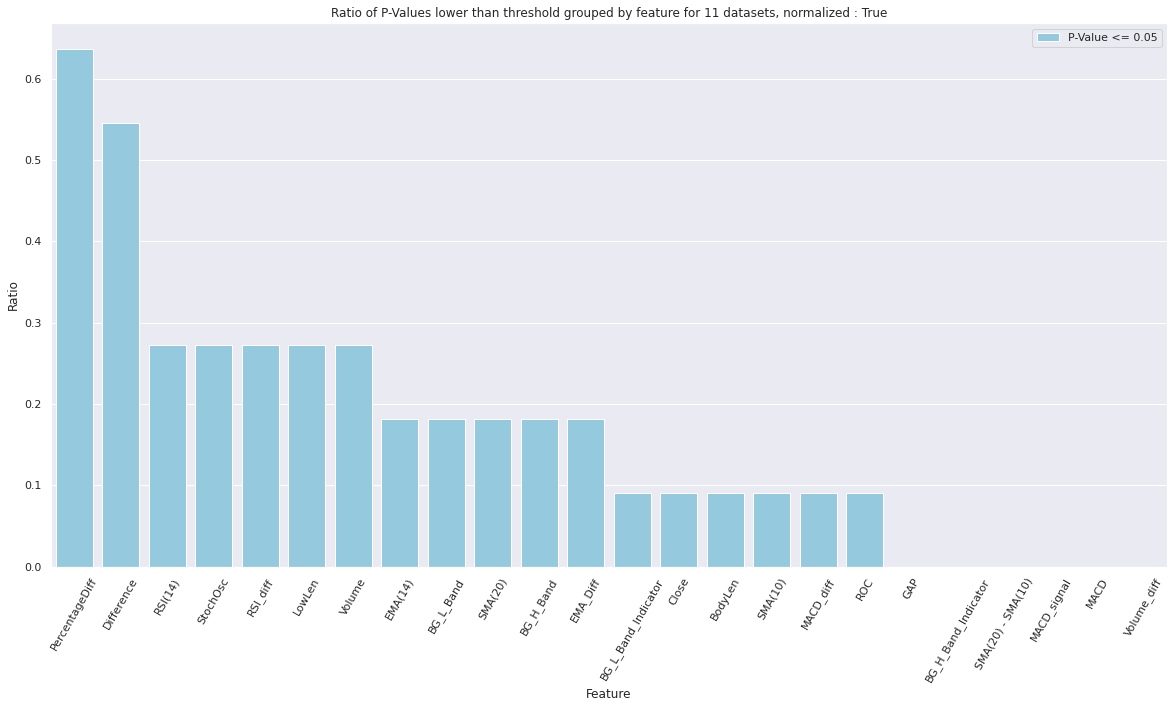

In [54]:
plt.figure(figsize=(20,10))

bar_lower = sns.barplot(x='Feature', y='Lower_Ratio', estimator=sum, data=df, color="skyblue", label=f"P-Value <= {P_THRESH}")
bar_lower.set_xticklabels(bar_lower.get_xticklabels(),rotation=60)
plt.title(f"Ratio of P-Values lower than threshold grouped by feature for {len(df_dict)} datasets, normalized : {NORMALIZE_FEATURES}")
plt.legend(loc='best')
plt.ylabel('Ratio')
plt.show()